## Demonstrating the Workflow of the Online_IO Class: Implicit Update

### Stephanie Allen, *AMSC PhD, UMD-College Park* 

We will demonstrate through the Markdown and code blocks below the workflow of the `Online_IO` class for the `Dong_implicit_update` option.  We will be replicating an experiment from Dong, Chen, & Zeng's 2018 paper, "Generalized Inverse Optimization through Online Learning" [1].  The algorithm is also from [1]; our contribution is the implementation, and the construction of the `Online_IO` class.

We will provide some explanation regarding creating an instance of the `Online_IO` class but, for detailed documentation and additional sources, see our chapter!

Environment set up comes first!  We then load in the experiment data.

In [1]:
import sys
sys.path.insert(0,"C:\\Users\\StephanieAllen\\Documents\\1_AMSC663\\Repository_for_Code")

import time
import pytest
import pdb #for debugging
import numpy as np                     
import pyomo.environ as pyo
from pyomo.opt import SolverFactory 
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.pyplot as plt #http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html#simple-plot
import pickle

from online_IO_files.online_IO_source.online_IO import Online_IO #importing the GIO class for testing
### Uncomment the line below to generate new data ###
#from experiment_dong_consumer_behavior_gen_data import num_samples,c_dict 
num_samples = 1000
c_dict = {1:-1.180,2:-1.733,3:-1.564,4:-0.040,5:-2.443,6:-1.055,\
          7:-4.760,8:-5.00,9:-1.258,10:-4.933} #made r negative since we will want to minimize



In [4]:
##### Step 0: Loading the Data & Set Up Model #####
###    Load Data    ###
loading_data_info = open("dong_p_t.pickle","rb")
p_t_samples = pickle.load(loading_data_info) 
loading_data_info.close()

loading_data_info2 = open("dong_y_t.pickle","rb")
y_t_samples = pickle.load(loading_data_info2)
loading_data_info2.close()

print("Demonstrating that random values were generated for p_t")
print("p_40",p_t_samples[40])
print("p_80",p_t_samples[80])
print("p_120",p_t_samples[120])
print("p_200",p_t_samples[200])

print("***********************************")

print("Demonstrating that we get different y_ts")
print("y_40",np.transpose(y_t_samples[40]))
print("y_80",np.transpose(y_t_samples[80]))
print("y_120",np.transpose(y_t_samples[120]))
print("y_200",np.transpose(y_t_samples[200]))


Demonstrating that random values were generated for p_t
p_40 {(1, 1): 6.872736000661441, (1, 2): 22.55538608126607, (1, 3): 6.712550204165577, (1, 4): 24.619824043226703, (1, 5): 22.144583139757525, (1, 6): 7.340982174692893, (1, 7): 23.282290818846857, (1, 8): 9.557741596860442, (1, 9): 12.31978637437463, (1, 10): 12.320182290647729}
p_80 {(1, 1): 8.614348491712231, (1, 2): 24.086267085995495, (1, 3): 16.05342716191431, (1, 4): 8.482225507053494, (1, 5): 12.838857921891343, (1, 6): 21.432258842394223, (1, 7): 14.70361316172956, (1, 8): 10.179237730280914, (1, 9): 12.60055028871529, (1, 10): 17.139352505347272}
p_120 {(1, 1): 20.137132092911408, (1, 2): 13.931209346373484, (1, 3): 24.765010480668302, (1, 4): 12.194302486825464, (1, 5): 5.297396766526521, (1, 6): 21.16884443252545, (1, 7): 14.470321219527992, (1, 8): 15.16583346926099, (1, 9): 22.381477328309604, (1, 10): 24.975066923857053}
p_200 {(1, 1): 22.186287801395707, (1, 2): 18.063477040722383, (1, 3): 7.667709796356723, (1, 4)

In setting up the model, users do need to define the model in terms of the standard form, with parameter objects defined for any of the available data below.  These parameters also need to be indexed using index sets.  Furthermore, users need to group equality and inequality constraints together into the appropriate parameter blocks:

$$\min\limits_{x} h(x) = \frac{1}{2} x^T Q x  + c^T x$$
$$Ax \leq b $$
$$Dx = \overline{f}$$

However, users can name the parameters differently than the symbols used in this model, and users do **not** need to define the entire model for the `Dong_implicit_update` option.  There are however a few algorithm specific requirements.  In the case of the Dong, Chen, & Zeng [1] algorithm, users have to have the full objective function (with both $c$ and $Q$) and $Q$ has to be positive definite.  Although we aren't extensively discussing the BMPS algorithm, we will note that, for [2], we advise against defining a $Q$.

Users need to define index sets and parameters that correspond to the ones above for which they have data.  For the feasible region, the requirement is that there is at least one constraint.  Remember, the goal is to estimate the linear portion of this objective function.

In [3]:
###    Set up Model    ###
#a. Sets and Vars
cb_model = pyo.ConcreteModel()
cb_model.varindex = pyo.RangeSet(1,10)
cb_model.x = pyo.Var(cb_model.varindex)
cb_model.numvars = pyo.Param(initialize=10)
cb_model.eqindex = pyo.RangeSet(1,1)

#b. Parameters
cb_model.p_t = pyo.Param(cb_model.eqindex,\
                        cb_model.varindex,initialize=0) 
                        #notice that the A matrix has two indices (1,#)

cb_model.bscalar = pyo.Param(cb_model.eqindex,initialize={1:40})

diag_vec = np.array([2.360,3.465,3.127,0.0791,4.886,2.110,\
        9.519,9.999,2.517,9.867]) 
Q = np.diag(diag_vec) 

def Q_param_rule(model,i,j): 
    return Q[i-1,j-1]

cb_model.Qmat = pyo.Param(cb_model.varindex,\
                cb_model.varindex,rule=Q_param_rule) #we could have used a dictionary to pass in the Q data

c_dict_dummy = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0} #initialization

cb_model.cvec = pyo.Param(cb_model.varindex,\
                               initialize=c_dict_dummy) #c looks like only needs one index per entry




Once we have defined our `pyomo` object, we can then create an instance of the `Online_IO` class to carry out our desired online inverse optimization algorithm.  The initialization of the instance is fairly straight-forward with a few caveats:
* If your model does not have data for one of the parameters, pass the 'None' string into its name (note that the string is case-sensitive).  This will ensure that the parameter is not included in mathematical model building
* For the `binary_mutable` list, you are indicating which parts of the model will be updated over time.  The order of the list is [$Q,c,A,b,D,\overline{f}$].  For now, **NEVER** place a 1 in the $c$ spot because it will (for now) be the part of the objective function that we are estimating.  Our mutability vector for this example required a 1 in the $A$ slot because $p_t$ varies with time. 
* If the variables $x$ are supposed to be non-negative, you **must** specify this by setting the `non_negative` flag equal to 1.
* See the `demo_Online_IO_class_template_etc.ipynb` Jupyter notebook for a general template for the `pyomo` model a user would need to construct to specify when creating an instance of the `Online_IO` class.
* See complete documentation for more information regarding all of this!

The first step in the `Online_IO` workflow after creating an instance of the `Online_IO` class is to initiate your chosen algorithm.  You currently have two options: 'Dong_implicit_update' and 'BMPS_online_GD.'  Since we are working with the experiment from [1], we pass 'Dong_implicit_update' to the `initialize_IO_method` method.

In [4]:
##### Step 1: Create an Instance of the Online_IO Class #####
##### & Initiate the Dong_implicit_update Algorithm #####

online_cb = Online_IO(cb_model,Qname='Qmat',cname='cvec',Aname='p_t',\
    bname='bscalar',Dname='None',fname='None',dimQ=(10,10),dimc=(10,1),\
    dimA=(1,10),dimD=(0,0),binary_mutable=[0,0,1,0,0,0],non_negative=1,\
                      feasible_set_C=(-5,0)) 

online_cb.initialize_IO_method("Dong_implicit_update")

We then run through the data, feeding one $p_t$ and one $y_t$ each iteration.  The `receive_data` method update the `KKT_conditions_model`, and `next_iteration` takes care of the running of the algorithm. [1]

In [5]:
##### Step 2-3: Iterate Through the Data and, for each iteration, #####
##### Run receive_data and next_iteration in Sequence #####

for i in range(1,num_samples+1):
    
    #### Step 2: Update Model with New Data ####
    online_cb.receive_data(p_t={"p_t":p_t_samples[i]},x_t=y_t_samples[i]) #receive data sample
                                                                    #remember that the p_t needs to be named by the parameter
    
    ## The next few statements do some basic checks.  They aren't comprehensive, but ##
    ## they are useful to showcase because they indicate some approaches to debugging pyomo models ##
    ## See documentation for sources regarding the pyomo package and its documentation (and some sites I found helpful) ##
    
    ##Checking that p_t gets put into the KKT_model##
    assert online_cb.KKT_conditions_model.A.extract_values() == p_t_samples[i]

    ### Checking some Pyomo flags for Constraint Integrity ###
    for constr in online_cb.KKT_conditions_model.component_objects(pyo.Constraint):
        assert constr._constructed == True, "Error in constraint construction (body)" 
        for c in constr:
            lb = pyo.value(constr[c].lower)
            ub = pyo.value(constr[c].upper)
            assert ((lb is not None) or (ub is not None)), "Error in constraint construction (LHS/RHS)"
    
    #### Step 3: Perform Update Rule ####
    online_cb.next_iteration(eta_factor=5) #go to the next iteration
    

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): 

This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): optimal
This is the termination condition (update rule): optimal
This is the termination condition (loss func): 

We then produce some graphs from our data.  See the documentation for more information about the specific graphs.

<Figure size 432x288 with 0 Axes>

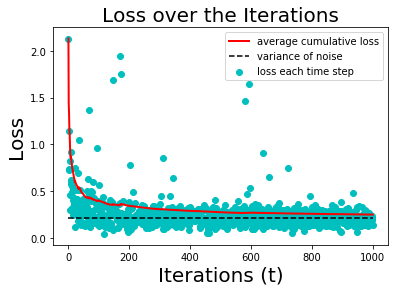

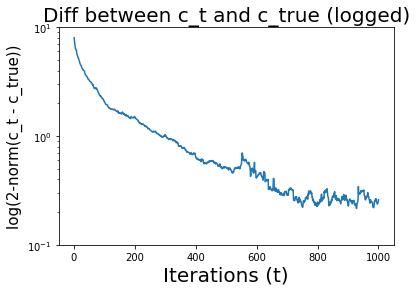

<Figure size 432x288 with 0 Axes>

In [6]:
##### Step 4a: Graph the Loss ##### 

losses = np.array(online_cb.losses_dong)
cumsum_losses = np.cumsum(losses)
average_cumsum_losses = np.divide(cumsum_losses,np.arange(1,num_samples+1))

losses_scatter = plt.scatter(np.arange(1,num_samples+1),losses,c='c',\
                    label="loss each time step")
losses_scatter = plt.plot(np.arange(1,num_samples+1),average_cumsum_losses,'r',\
                linewidth=2,label="average cumulative loss")
losses_scatter = plt.plot(np.arange(1,num_samples+1),0.2083*np.ones((num_samples,)),\
                          '--k',label="variance of noise")

plt.legend()
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Loss over the Iterations',fontsize=20)
plt.figure()

##### Step 4b: Graph 2-Norm Between c_t and c_true #####
    
#c_dict has the true (negated) r
c_ph = np.zeros((10,))
for j in range(1,11):
    c_ph[j-1] = c_dict[j]

c_error = np.zeros((num_samples,))

for i in range(1,num_samples+1):
    ph = online_cb.c_t_dict_dong[i]
    ph_np = np.zeros((10,))
    for j in range(1,11):
        ph_np[j-1] = ph[j]
    c_error[i-1] = np.linalg.norm(ph_np - c_ph)
     
error_in_c_graph = plt.semilogy(np.arange(1,num_samples+1),c_error)
plt.ylim((10**(-1),10))
plt.xlabel('Iterations (t)',fontsize=20)
plt.ylabel('log(2-norm(c_t - c_true))',fontsize=15)
plt.title('Diff between c_t and c_true (logged)',fontsize=20)
plt.figure()


### Selected References (see documentation for more)

[1] Dong, Chaosheng, Yiran Chen, and Bo Zeng. "Generalized Inverse Optimization through Online Learning." *Advances in Neural Information Processing Systems*. 2018.

[2] Bärmann, Andreas, Alexander Martin, Sebastian Pokutta, and Oskar Schneider. "An Online-Learning Approach to Inverse Optimization." arXiv preprint arXiv:1810.12997 (2018).